# Model Generalization: A Sharpness Aware Optimization Perspective

Please download all the content in https://drive.google.com/drive/folders/1n5prGBjSys3Fma76MbYSd94Sx5fImFH6?usp=sharing to `runs` folder

In [1]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
sns.set()

Some helper functions

In [2]:
def get_data(folder='acc/', filename='*bz_16*[sam]*'):
    data_all = []
    for file in glob.glob(folder+filename):
        data = pd.read_csv(file)['Value'].to_list()
        data_all.append(data)
    opt_type = filename.split('*')[2]
    if opt_type == 'none': opt_type = 'SGD'
    if opt_type == 'sam': opt_type = 'SAM'
    name = filename.split('*')[1] + ' ' + opt_type
    data = np.array(data_all)
    return name, data

In [3]:
def get_first_layer_weights(path):
    state_dict = torch.load(path)
    return list(state_dict['model_state_dict'].items())[0][1].flatten().cpu().numpy()

## Experiment 1 & 2

In [4]:
name_list = [
    '*bz_16*sam*', '*bz_64*sam*', '*bz_128*sam*',
    '*bz_16*none*', '*bz_64*none*', '*bz_128*none*',
]

bz_16 SAM [0.79930001 0.80409998 0.80140001]
bz_64 SAM [0.74970001 0.74809998 0.75389999]
bz_128 SAM [0.71219999 0.70779997 0.7098    ]
bz_16 SGD [0.759      0.755      0.75550002]
bz_64 SGD [0.70590001 0.70450002 0.70520002]
bz_128 SGD [0.65149999 0.64029998 0.64170003]


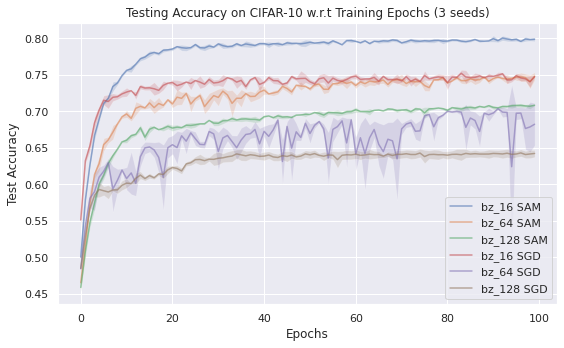

In [5]:
plt.subplots(1, figsize=(8, 5))
for i, dset in enumerate(name_list):
    name, data = get_data('acc/', dset)
    
    # Report accuracy of SAM (50) and SGD(100)
    if 'SAM' in name:
        print(name, data[:50].max(1))
    elif 'SGD' in name:
        print(name, data.max(1))
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    num_curves = data.shape[0]
    epochs = data.shape[1]
    plt.plot(np.arange(epochs), mean, label=name, alpha=0.6)
    plt.fill_between(np.arange(epochs), mean-std, mean+std, alpha=0.2)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Test Accuracy')
    plt.title('Testing Accuracy on CIFAR-10 w.r.t Training Epochs (3 seeds)')
plt.tight_layout()
plt.savefig('test_acc.pdf')

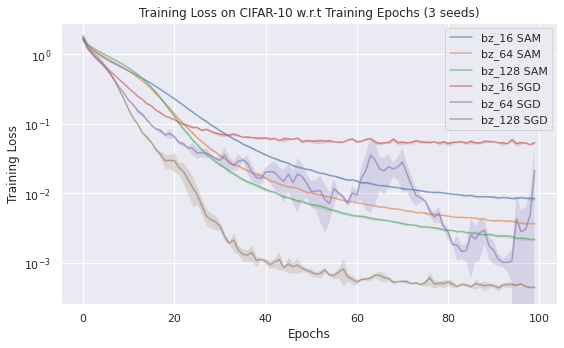

In [6]:
plt.subplots(1, figsize=(8, 5))
plt.yscale('log')
for i, dset in enumerate(name_list):
    name, data = get_data('loss/', dset)
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    num_curves = data.shape[0]
    epochs = data.shape[1]
    plt.plot(np.arange(epochs), mean, label=name, alpha=0.6)
    plt.fill_between(np.arange(epochs), mean-std, mean+std, alpha=0.2)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.title('Training Loss on CIFAR-10 w.r.t Training Epochs (3 seeds)')
plt.tight_layout()
plt.savefig('train_loss.pdf')

## Experiment 3

In [7]:
# Loading the data

asam_layer_1 = get_first_layer_weights('../runs/bz_128_seed_1_epochs[200]_model_resnet18_baseoptim[sgd]_secoptim[asam]_norm_none_batchnorm_False_lr_0.01_momentum_0.9_rho_0.5_cos_True.pt')

b_norm_asam_layer_1 = get_first_layer_weights('../runs/bz_128_seed_1_epochs[200]_model_resnet18_baseoptim[sgd]_secoptim[asam]_norm_none_batchnorm_True_lr_0.01_momentum_0.9_rho_0.5_cos_True.pt')

sam_layer_1 = get_first_layer_weights('../runs/bz_128_seed_1_epochs[200]_model_resnet18_baseoptim[sgd]_secoptim[sam]_norm_none_batchnorm_False_lr_0.01_momentum_0.9_rho_0.05_cos_True.pt')

b_norm_sam_layer_1 = get_first_layer_weights('../runs/bz_128_seed_1_epochs[200]_model_resnet18_baseoptim[sgd]_secoptim[sam]_norm_none_batchnorm_True_lr_0.01_momentum_0.9_rho_0.05_cos_True.pt')

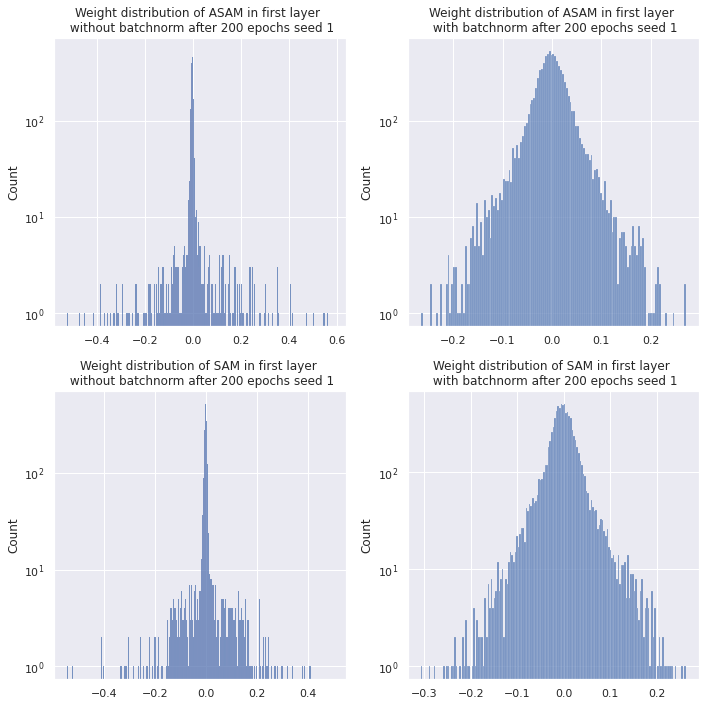

In [8]:
font = {'size'   : 13}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(2,2, figsize=(10,10))
axs = axs.ravel()

ax = sns.histplot(asam_layer_1, ax=axs[0])
ax.set(title='Weight distribution of ASAM in first layer \n without batchnorm after 200 epochs seed 1', yscale='log')

ax = sns.histplot(b_norm_asam_layer_1, ax=axs[1])
ax.set(title='Weight distribution of ASAM in first layer \n with batchnorm after 200 epochs seed 1', yscale='log')


ax = sns.histplot(sam_layer_1, ax=axs[2])
ax.set(title='Weight distribution of SAM in first layer \n without batchnorm after 200 epochs seed 1', yscale='log')

ax = sns.histplot(b_norm_sam_layer_1, ax=axs[3])
ax.set(title='Weight distribution of SAM in first layer \n with batchnorm after 200 epochs seed 1', yscale='log')

plt.tight_layout()
plt.savefig("Weight_distribution_first_layer.jpg", dpi=400)
plt.show()

In [9]:
def get_data_asam(folder='acc/', filename='*bz_16*[sam]*'):
    data_all = []
    for file in glob.glob(folder+filename):
        data = pd.read_csv(file)['Value'].to_list()
        data_all.append(data)
    opt_type = filename.split('*')[0]
    name = filename.split('*')[1] + ' ' + opt_type
    data = np.array(data_all)

    return name, data

[[0.30320001 0.44389999 0.50459999 ... 0.68660003 0.68660003 0.68650001]
 [0.2969     0.4409     0.4948     ... 0.70039999 0.70060003 0.70060003]
 [0.30379999 0.41139999 0.47040001 ... 0.65759999 0.65759999 0.6577    ]
 [0.2649     0.36250001 0.4488     ... 0.65439999 0.65429997 0.65439999]
 [0.26890001 0.403      0.45159999 ... 0.66250002 0.66250002 0.66229999]
 [0.2527     0.38409999 0.4454     ... 0.65469998 0.65469998 0.65490001]]
[[0.30320001 0.44389999 0.50459999 0.52509999 0.56889999 0.59979999
  0.60579997 0.61629999 0.62800002 0.63370001 0.64300001 0.65060002
  0.65109998 0.6476     0.63810003 0.65509999 0.65319997 0.64429998
  0.63810003 0.64990002 0.65280002 0.64840001 0.64840001 0.6512
  0.6512     0.65109998 0.65579998 0.65310001 0.65319997 0.65979999
  0.65719998 0.65939999 0.65719998 0.65859997 0.65960002 0.65570003
  0.65869999 0.66219997 0.65960002 0.66659999 0.66979998 0.66579998
  0.67000002 0.66869998 0.66409999 0.67019999 0.66829997 0.67009997
  0.66329998 0.670199

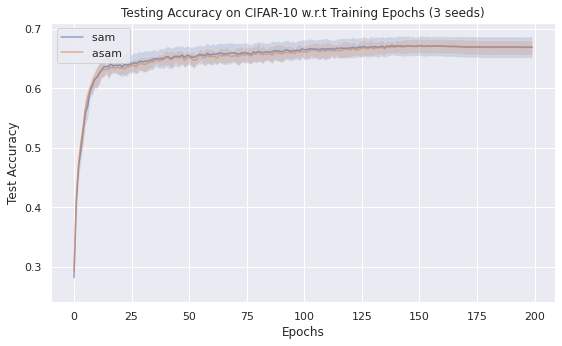

In [10]:
name_list = [
    '*sam*', '*asam*'
]

plt.subplots(1, figsize=(8, 5))
for i, dset in enumerate(name_list):
    name, data = get_data_asam('acc/Asam_SAM/', dset)
    print(data)
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    num_curves = data.shape[0]
    epochs = data.shape[1]
    plt.plot(np.arange(epochs), mean, label=name, alpha=0.6)
    plt.fill_between(np.arange(epochs), mean-std, mean+std, alpha=0.2)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Test Accuracy')
    plt.title('Testing Accuracy on CIFAR-10 w.r.t Training Epochs (3 seeds)')
plt.tight_layout()
plt.savefig('test_acc_sam_asam.pdf')

8.70273318246156e-05
1.2588990855920329e-05


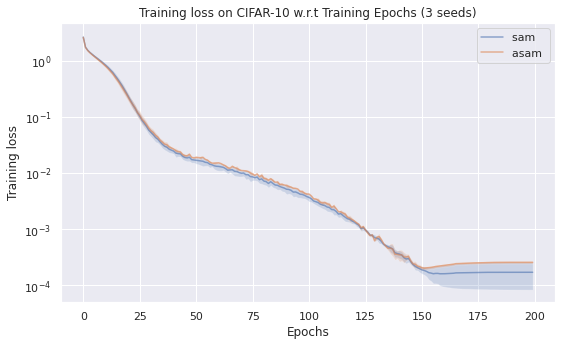

In [11]:
name_list = [
    '*sam*', '*asam*'
]

plt.subplots(1, figsize=(8, 5))
plt.yscale('log')
for i, dset in enumerate(name_list):
    name, data = get_data_asam('loss/Asam_SAM/', dset)

    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    print(std[-1])
    num_curves = data.shape[0]
    epochs = data.shape[1]
    plt.plot(np.arange(epochs), mean, label=name, alpha=0.6)
    plt.fill_between(np.arange(epochs), mean-std, mean+std, alpha=0.2)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Training loss')
    plt.title('Training loss on CIFAR-10 w.r.t Training Epochs (3 seeds)')
plt.tight_layout()
plt.savefig('train_loss_sam_asam.pdf')

## Sharpness Calculation

In [12]:
## perturb the weights in each modules
state = torch.load('../runs/bz_16_seed_20_epochs[100]_model_resnet18_baseoptim[sgd]_secoptim[none]_norm_normalize_batchnorm_True_lr_0.01_momentum_0_rho_0.05_cos_False.pt')

# Out of distribution test (Unused in the paper)

In [13]:
from torchvision.transforms import transforms
import torchvision
from torchvision import models

def get_ood_eval(path, ood='mult'):
    if ood == 'mult':
        ood_scales = [1 + n * 0.25 for n in range(15)]
    elif ood == 'add':
        ood_scales = [ n * 0.1 for n in range(15)]
    elif ood == 'rot':
        ood_scales = [ n for n in range(15)]
    accuracies = []
    for ood_scale in ood_scales:
        state_dict = torch.load(path)
        model = models.resnet18(pretrained=False)
        model.load_state_dict(state_dict['model_state_dict'])
        model.to('cuda')
        if ood == 'mult':
            ood_transform = transforms.Lambda(lambda x: x * ood_scale)
        elif ood == 'add':
            ood_transform = transforms.Lambda(lambda x: x + ood_scale)
        elif ood == 'rot':
            ood_transform = transforms.RandomRotation((ood_scale, ood_scale))
            
        testset = torchvision.datasets.CIFAR10(root='./../data', train=False, download=True, transform=transforms.Compose(
                    [transforms.ToTensor(),
                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                     ood_transform]))

        testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                                              shuffle=False, num_workers=2)
        total_correct = 0
        total = 0
        model.eval()
        # again no gradients needed
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to('cuda'), labels.to('cuda')
                outputs = model(images)
                _, predictions = torch.max(outputs, 1)
                # collect the correct predictions for each class
                for label, prediction in zip(labels, predictions):
                    total += 1
                    if label == prediction:
                        total_correct += 1

        accuracies.append(total_correct / total)
        print(f"Accuracy {total_correct / total}")
    return accuracies, ood_scales


In [14]:
base_path = '../runs'
sgd_model_path = 'bz_16_seed_20_epochs[100]_model_resnet18_baseoptim[sgd]_secoptim[none]_norm_normalize_batchnorm_True_lr_0.01_momentum_0_rho_0.05_cos_False.pt'
sam_model_path = 'bz_16_seed_20_epochs[100]_model_resnet18_baseoptim[sgd]_secoptim[sam]_norm_normalize_batchnorm_True_lr_0.01_momentum_0_rho_0.05_cos_False.pt'
sgd_accuracies, ood_scales = get_ood_eval(base_path + '/' + sgd_model_path)

Files already downloaded and verified
Accuracy 0.748
Files already downloaded and verified
Accuracy 0.7396
Files already downloaded and verified
Accuracy 0.719
Files already downloaded and verified
Accuracy 0.6963
Files already downloaded and verified
Accuracy 0.6688
Files already downloaded and verified
Accuracy 0.6442
Files already downloaded and verified
Accuracy 0.6184
Files already downloaded and verified
Accuracy 0.5933
Files already downloaded and verified
Accuracy 0.576
Files already downloaded and verified
Accuracy 0.559
Files already downloaded and verified
Accuracy 0.541
Files already downloaded and verified
Accuracy 0.5229
Files already downloaded and verified
Accuracy 0.5071
Files already downloaded and verified
Accuracy 0.4914
Files already downloaded and verified
Accuracy 0.4789


In [15]:
sam_accuracies, _ = get_ood_eval(base_path + '/' + sam_model_path)

Files already downloaded and verified
Accuracy 0.7963
Files already downloaded and verified
Accuracy 0.7873
Files already downloaded and verified
Accuracy 0.7705
Files already downloaded and verified
Accuracy 0.7456
Files already downloaded and verified
Accuracy 0.7213
Files already downloaded and verified
Accuracy 0.6991
Files already downloaded and verified
Accuracy 0.6791
Files already downloaded and verified
Accuracy 0.6577
Files already downloaded and verified
Accuracy 0.6383
Files already downloaded and verified
Accuracy 0.6222
Files already downloaded and verified
Accuracy 0.6042
Files already downloaded and verified
Accuracy 0.5892
Files already downloaded and verified
Accuracy 0.5744
Files already downloaded and verified
Accuracy 0.5598
Files already downloaded and verified
Accuracy 0.5447


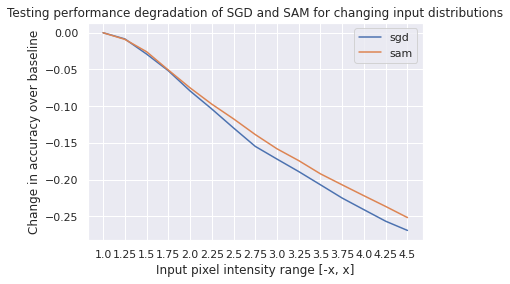

In [16]:
font = {'size'   : 12}
matplotlib.rc('font', **font)
figure = plt.figure(figsize=(6,4))
plt.plot(ood_scales, [x - sgd_accuracies[0] for x in sgd_accuracies], label = 'sgd')
plt.plot(ood_scales, [x - sam_accuracies[0] for x in sam_accuracies], label = 'sam')
plt.xticks(ood_scales, ood_scales)
plt.xlabel('Input pixel intensity range [-x, x]')
plt.ylabel('Change in accuracy over baseline')
plt.title('Testing performance degradation of SGD and SAM for changing input distributions')
plt.legend()

In [17]:
base_path = '../runs'
sgd_model_path = 'bz_16_seed_20_epochs[100]_model_resnet18_baseoptim[sgd]_secoptim[none]_norm_normalize_batchnorm_True_lr_0.01_momentum_0_rho_0.05_cos_False.pt'
sam_model_path = 'bz_16_seed_20_epochs[100]_model_resnet18_baseoptim[sgd]_secoptim[sam]_norm_normalize_batchnorm_True_lr_0.01_momentum_0_rho_0.05_cos_False.pt'
sgd_accuracies, ood_scales = get_ood_eval(base_path + '/' + sgd_model_path, ood='add')
sam_accuracies, _ = get_ood_eval(base_path + '/' + sam_model_path, ood='add')

Files already downloaded and verified
Accuracy 0.748
Files already downloaded and verified
Accuracy 0.7432
Files already downloaded and verified
Accuracy 0.7333
Files already downloaded and verified
Accuracy 0.7162
Files already downloaded and verified
Accuracy 0.6989
Files already downloaded and verified
Accuracy 0.6703
Files already downloaded and verified
Accuracy 0.6357
Files already downloaded and verified
Accuracy 0.601
Files already downloaded and verified
Accuracy 0.5589
Files already downloaded and verified
Accuracy 0.5154
Files already downloaded and verified
Accuracy 0.4764
Files already downloaded and verified
Accuracy 0.4368
Files already downloaded and verified
Accuracy 0.4056
Files already downloaded and verified
Accuracy 0.368
Files already downloaded and verified
Accuracy 0.3386
Files already downloaded and verified
Accuracy 0.7963
Files already downloaded and verified
Accuracy 0.7958
Files already downloaded and verified
Accuracy 0.7893
Files already downloaded and ve

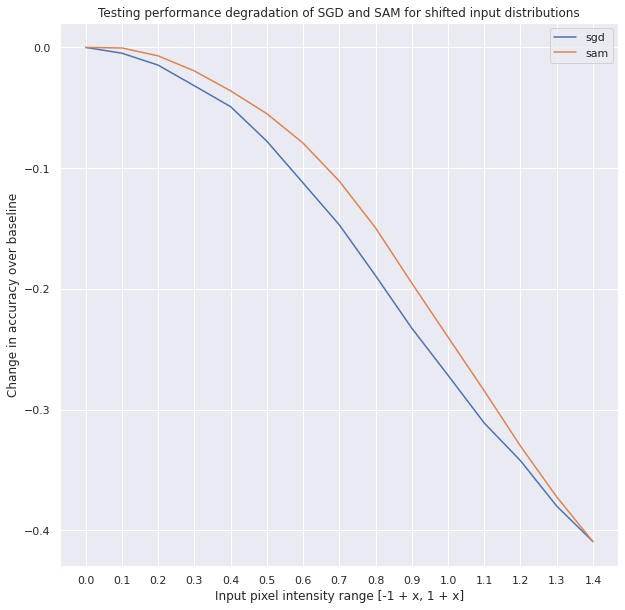

In [18]:
figure = plt.figure(figsize=(10,10))
plt.plot(ood_scales, [x - sgd_accuracies[0] for x in sgd_accuracies], label = 'sgd')
plt.plot(ood_scales, [x - sam_accuracies[0] for x in sam_accuracies], label = 'sam')
plt.xticks(ood_scales, [round(x, 4) for x in ood_scales])
plt.xlabel('Input pixel intensity range [-1 + x, 1 + x]')
plt.ylabel('Change in accuracy over baseline')
plt.title('Testing performance degradation of SGD and SAM for shifted input distributions')
plt.legend()

In [19]:
base_path = '../runs'
sgd_model_path = 'bz_16_seed_20_epochs[100]_model_resnet18_baseoptim[sgd]_secoptim[none]_norm_normalize_batchnorm_True_lr_0.01_momentum_0_rho_0.05_cos_False.pt'
sam_model_path = 'bz_16_seed_20_epochs[100]_model_resnet18_baseoptim[sgd]_secoptim[sam]_norm_normalize_batchnorm_True_lr_0.01_momentum_0_rho_0.05_cos_False.pt'
sgd_accuracies, ood_scales = get_ood_eval(base_path + '/' + sgd_model_path, ood='rot')

Files already downloaded and verified
Accuracy 0.748
Files already downloaded and verified
Accuracy 0.748
Files already downloaded and verified
Accuracy 0.7455
Files already downloaded and verified
Accuracy 0.7269
Files already downloaded and verified
Accuracy 0.7263
Files already downloaded and verified
Accuracy 0.7184
Files already downloaded and verified
Accuracy 0.7146
Files already downloaded and verified
Accuracy 0.7045
Files already downloaded and verified
Accuracy 0.6973
Files already downloaded and verified
Accuracy 0.6851
Files already downloaded and verified
Accuracy 0.6851
Files already downloaded and verified
Accuracy 0.6708
Files already downloaded and verified
Accuracy 0.6564
Files already downloaded and verified
Accuracy 0.6496
Files already downloaded and verified
Accuracy 0.6391


In [20]:
sam_accuracies, _ = get_ood_eval(base_path + '/' + sam_model_path, ood='rot')

Files already downloaded and verified
Accuracy 0.7963
Files already downloaded and verified
Accuracy 0.7963
Files already downloaded and verified
Accuracy 0.7899
Files already downloaded and verified
Accuracy 0.7734
Files already downloaded and verified
Accuracy 0.7653
Files already downloaded and verified
Accuracy 0.7667
Files already downloaded and verified
Accuracy 0.7596
Files already downloaded and verified
Accuracy 0.7457
Files already downloaded and verified
Accuracy 0.74
Files already downloaded and verified
Accuracy 0.7316
Files already downloaded and verified
Accuracy 0.7209
Files already downloaded and verified
Accuracy 0.7087
Files already downloaded and verified
Accuracy 0.6966
Files already downloaded and verified
Accuracy 0.6848
Files already downloaded and verified
Accuracy 0.6781


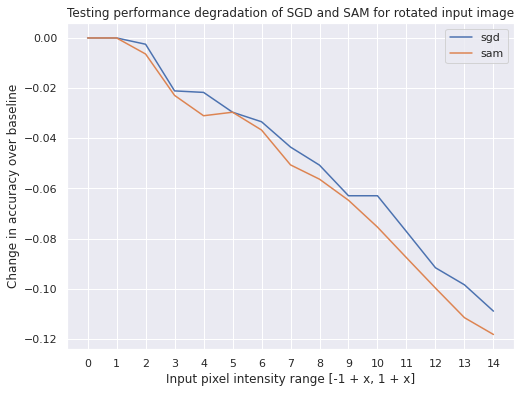

In [21]:
figure = plt.figure(figsize=(8,6))
plt.plot(ood_scales, [x - sgd_accuracies[0] for x in sgd_accuracies], label = 'sgd')
plt.plot(ood_scales, [x - sam_accuracies[0] for x in sam_accuracies], label = 'sam')
plt.xticks(ood_scales, [round(x, 4) for x in ood_scales])
plt.xlabel('Input pixel intensity range [-1 + x, 1 + x]')
plt.ylabel('Change in accuracy over baseline')
plt.title('Testing performance degradation of SGD and SAM for rotated input image')
plt.legend()

## Sharpness calculation